<a href="https://colab.research.google.com/github/arcanekrishna/Soil_Classification/blob/main/Soil_type_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c soil-classification

 61% 88.0M/144M [00:00<00:00, 865MB/s]
100% 144M/144M [00:00<00:00, 475MB/s] 


In [3]:
!unzip soil-classification.zip

Archive:  soil-classification.zip
  inflating: soil_classification-2025/sample_submission.csv  
  inflating: soil_classification-2025/test/img_000f12db.jpg  
  inflating: soil_classification-2025/test/img_00a44450.jpg  
  inflating: soil_classification-2025/test/img_00af6b3b.jpg  
  inflating: soil_classification-2025/test/img_01a3f913.jpg  
  inflating: soil_classification-2025/test/img_01e540fc.jpg  
  inflating: soil_classification-2025/test/img_01f10d6d.jpg  
  inflating: soil_classification-2025/test/img_0218aefa.jpg  
  inflating: soil_classification-2025/test/img_0225b7de.jpg  
  inflating: soil_classification-2025/test/img_02c09374.jpg  
  inflating: soil_classification-2025/test/img_03137c54.jpg  
  inflating: soil_classification-2025/test/img_036e203a.jpg  
  inflating: soil_classification-2025/test/img_0387435e.jpg  
  inflating: soil_classification-2025/test/img_04309e41.jpeg  
  inflating: soil_classification-2025/test/img_04692c6c.jpg  
  inflating: soil_classification-20

In [4]:
import os
import cv2

import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [5]:
class OtsuSegmentation:
    def __call__(self, image):
        # Convert PIL image to NumPy array
        img_np = np.array(image)
        # Convert to grayscale
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        # Apply Otsu's thresholding
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # Normalize mask to 0 and 1
        mask = mask / 255.0
        # Apply mask to each channel
        segmented = img_np * mask[:, :, np.newaxis]
        # Convert back to uint8
        segmented = segmented.astype(np.uint8)
        # Convert back to PIL image
        return Image.fromarray(segmented)

In [6]:
# Transformation pipeline for training (with augmentation)
train_transform = transforms.Compose([
    OtsuSegmentation(),  # Segment soil pixels
    transforms.RandomHorizontalFlip(),  # Random flip for augmentation
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),  # Random rotation up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color adjustments
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Transformation pipeline for validation and test (no augmentation)
val_transform = transforms.Compose([
    OtsuSegmentation(),  # Segment soil pixels
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Custom Dataset class for training and validation
class SoilDataset(Dataset):
    def __init__(self, image_ids, labels, image_dir, transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        label = self.labels[idx]
        img_path = os.path.join(self.image_dir, f"{img_id}")  # Adjust extension if needed
        image = Image.open(img_path).convert('RGB')  # Load image
        if self.transform:
            image = self.transform(image)  # Apply transformations
        return image, label

# Custom Dataset class for test data (no labels)
class SoilTestDataset(Dataset):
    def __init__(self, image_ids, image_dir, transform=None):
        self.image_ids = image_ids
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{img_id}")  # Adjust extension if needed
        image = Image.open(img_path).convert('RGB')  # Load image
        if self.transform:
            image = self.transform(image)  # Apply transformations
        return image, img_id

# Function to visualize original and processed images with labels
def visualize_sample(image_id, encoded_label, le, image_dir, transform):
    img_path = os.path.join(image_dir, f"{image_id}")  # Adjust extension if needed
    original_image = Image.open(img_path).convert('RGB')  # Load original image

    # Apply transformation
    processed_image = transform(original_image)

    # Convert processed tensor back to NumPy for visualization
    processed_np = processed_image.numpy().transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]

    # Inverse normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    processed_np = (processed_np * std + mean) * 255  # Scale back to [0, 255]
    processed_np = processed_np.astype(np.uint8)

    # Decode label
    label_name = le.inverse_transform([encoded_label])[0]

    # Plot images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[1].imshow(processed_np)
    axes[1].set_title(f'Processed Image\nLabel: {label_name}')
    for ax in axes:
        ax.axis('off')
    plt.show()



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Visualizing 3 training samples:


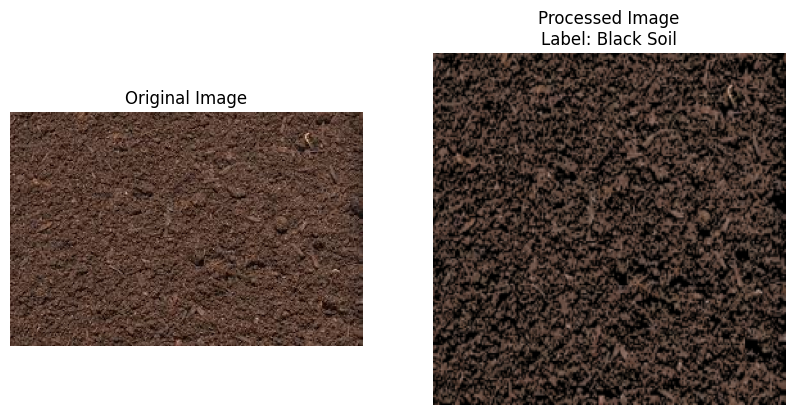

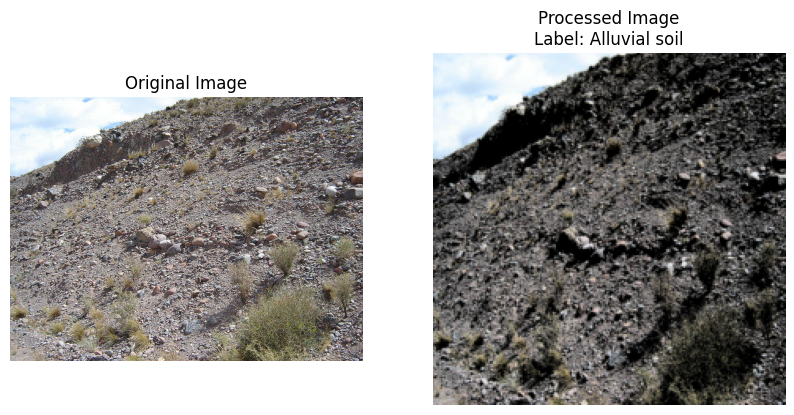

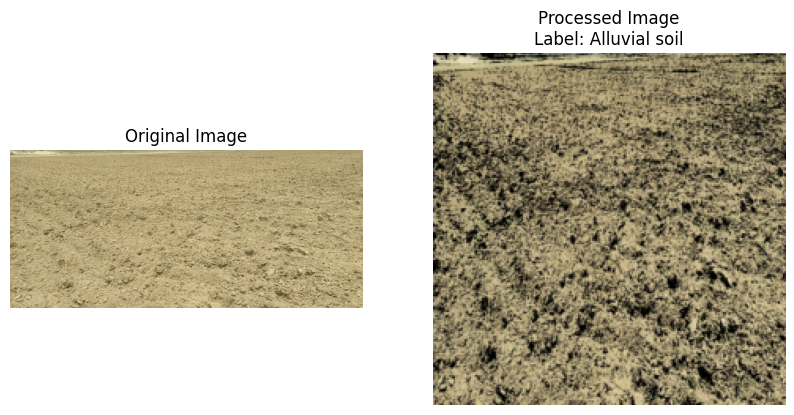

In [7]:
# Paths to the datasets
train_labels_path = '/content/soil_classification-2025/train_labels.csv'
train_images_dir = '/content/soil_classification-2025/train'
test_images_dir = '/content/soil_classification-2025/test'
    # Load training data
train_df = pd.read_csv(train_labels_path)

    # Encode labels
le = LabelEncoder()
train_df['soil_type_encoded'] = le.fit_transform(train_df['soil_type'])

# Split data by the method of stratified sampling
train_ids, val_ids, train_labels, val_labels = train_test_split(
        train_df['image_id'], train_df['soil_type_encoded'],
        test_size=0.2, stratify=train_df['soil_type_encoded'], random_state=42
    )

    # Create datasets with appropriate transforms
train_dataset = SoilDataset(train_ids.tolist(), train_labels.tolist(), train_images_dir, transform=train_transform)
val_dataset = SoilDataset(val_ids.tolist(), val_labels.tolist(), train_images_dir, transform=val_transform)

    # Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Load test data
test_ids = pd.read_csv('/content/soil_classification-2025/test_ids.csv')['image_id']

    # Create test dataset
test_dataset = SoilTestDataset(test_ids.tolist(), test_images_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Visualize samples using val_transform for consistency
print("Visualizing 3 training samples:")
for i in range(3):
    image_id = train_ids.iloc[i]
    encoded_label = train_labels.iloc[i]
    visualize_sample(image_id, encoded_label, le, train_images_dir, val_transform)


In [8]:
import torch
import torch.nn as nn
from torchvision import models # Import the models module here
import torch.optim as optim
from sklearn.metrics import f1_score
class NonLocalBlock(nn.Module):
    def __init__(self, in_channels):
        super(NonLocalBlock, self).__init__()
        self.in_channels = in_channels
        self.inter_channels = in_channels // 2  # 1280 // 2 = 640
        self.g = nn.Conv2d(in_channels, self.inter_channels, kernel_size=1)
        self.theta = nn.Conv2d(in_channels, self.inter_channels, kernel_size=1)
        self.phi = nn.Conv2d(in_channels, self.inter_channels, kernel_size=1)
        self.W = nn.Conv2d(self.inter_channels, in_channels, kernel_size=1)
        # Initialize W to zero for residual connection
        nn.init.constant_(self.W.weight, 0)
        nn.init.constant_(self.W.bias, 0)

    def forward(self, x):
        batch_size = x.size(0)

        # Compute projections
        theta_x = self.theta(x).view(batch_size, self.inter_channels, -1).permute(0, 2, 1)  # [batch_size, H*W, 640]
        phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)  # [batch_size, 640, H*W]
        g_x = self.g(x).view(batch_size, self.inter_channels, -1).permute(0, 2, 1)  # [batch_size, H*W, 640]

        # Compute spatial attention map
        f = torch.matmul(theta_x, phi_x)  # [batch_size, H*W, 640] @ [batch_size, 640, H*W] → [batch_size, H*W, H*W]
        f_div_C = torch.nn.functional.softmax(f, dim=-1)  # [batch_size, H*W, H*W]

        # Apply attention to g_x
        y = torch.matmul(f_div_C, g_x)  # [batch_size, H*W, H*W] @ [batch_size, H*W, 640] → [batch_size, H*W, 640]
        y = y.permute(0, 2, 1).contiguous().view(batch_size, self.inter_channels, *x.size()[2:])  # [batch_size, 640, H, W]

        # Restore channel dimension and add residual
        y = self.W(y)  # [batch_size, 1280, H, W]
        z = y + x  # Residual connection
        return z

# Example usage in SoilClassifier for binary classification soil image or not
# Soil Classifier Model
class SoilClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(SoilClassifier, self).__init__()
        base_model = models.efficientnet_b0(pretrained=True)
        self.features = base_model.features
        self.non_local = NonLocalBlock(1280)  # Matches EfficientNet-B0's last conv layer channels
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.non_local(x)
        x = self.classifier(x)
        return x

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 184MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total

Epoch 1/8 - Validation F1 per class: [0.80508475 0.67368421 0.79452055 0.6744186 ], Min F1: 0.6737


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/8 - Validation F1 per class: [0.87378641 0.81818182 0.86046512 0.8       ], Min F1: 0.8000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/8 - Validation F1 per class: [0.87878788 0.85416667 0.87804878 0.84210526], Min F1: 0.8421


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/8 - Validation F1 per class: [0.89855072 0.88172043 0.87058824 0.8952381 ], Min F1: 0.8706


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/8 - Validation F1 per class: [0.93953488 0.91666667 0.925      0.92929293], Min F1: 0.9167


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/8 - Validation F1 per class: [0.9478673  0.89583333 0.8974359  0.93333333], Min F1: 0.8958


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/8 - Validation F1 per class: [0.95145631 0.94736842 0.925      0.93577982], Min F1: 0.9250


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/8 - Validation F1 per class: [0.94174757 0.92783505 0.88888889 0.94339623], Min F1: 0.8889
Best Min F1: 0.9250


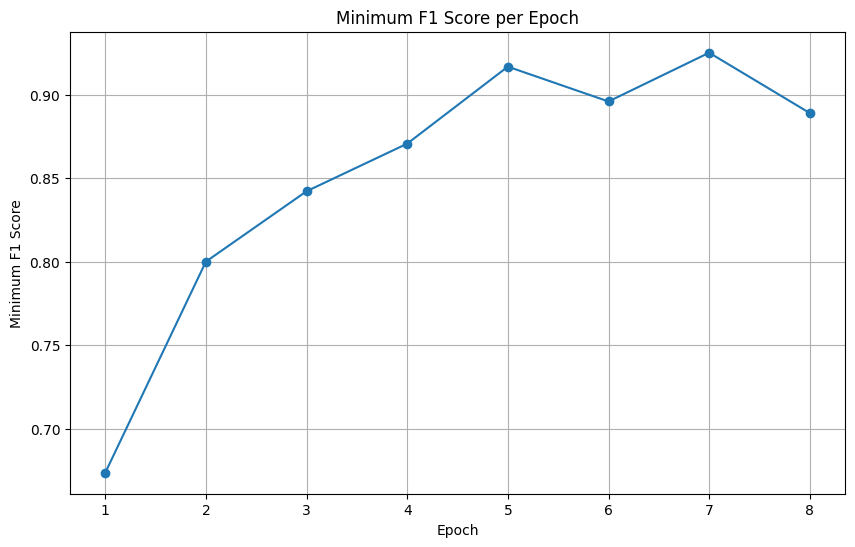

In [9]:
# prompt: i want to visualise the graph of f1 score for every epoch after model is trained

def train_and_evaluate(train_loader, val_loader, model, criterion, optimizer, num_epochs, le):

    best_min_f1 = 0.0
    epoch_f1_scores = []  # List to store min F1 score for each epoch

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.numpy())

        f1_scores = f1_score(all_labels, all_preds, average=None)
        min_f1 = f1_scores.min()
        epoch_f1_scores.append(min_f1)  # Store the min F1 score for the current epoch

        print(f"Epoch {epoch+1}/{num_epochs} - Validation F1 per class: {f1_scores}, Min F1: {min_f1:.4f}")

        if min_f1 > best_min_f1:
            best_min_f1 = min_f1
            torch.save(model.state_dict(), 'best_soil_classifier.pth')

    print(f"Best Min F1: {best_min_f1:.4f}")

    # Plotting the F1 score graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), epoch_f1_scores, marker='o', linestyle='-')
    plt.title('Minimum F1 Score per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Minimum F1 Score')
    plt.grid(True)
    plt.xticks(range(1, num_epochs + 1))
    plt.show()

    return best_min_f1, epoch_f1_scores

# Model, Loss, Optimizer
num_classes = len(le.classes_)
model = SoilClassifier(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Train & Evaluate and capture the F1 scores
best_min_f1, f1_scores_per_epoch = train_and_evaluate(train_loader, val_loader, model, criterion, optimizer,
                                                    num_epochs=8, le=le)


In [10]:
model.load_state_dict(torch.load('best_soil_classifier.pth'))
model.eval()

test_preds = []
test_image_ids = []

with torch.no_grad():
    for images, image_ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_image_ids.extend(image_ids)

# Convert predicted integer labels back to original soil type names
predicted_soil_types = le.inverse_transform(test_preds)

# Create submission DataFrame
submission_df = pd.DataFrame({'image_id': test_image_ids, 'soil_type': predicted_soil_types})

# Save submission file
submission_df.to_csv('submissionn.csv', index=False)

print("Prediction on test set complete. Submission file 'submission.csv' created.")
print(submission_df.head())

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Prediction on test set complete. Submission file 'submission.csv' created.
            image_id      soil_type
0  img_cdf80d6f.jpeg  Alluvial soil
1   img_c0142a80.jpg  Alluvial soil
2   img_91168fb0.jpg  Alluvial soil
3   img_9822190f.jpg  Alluvial soil
4  img_e5fc436c.jpeg       Red soil
